<a href="https://colab.research.google.com/github/VRB01/capstone/blob/main/Tranformer_ourdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import os
import numpy
from keras.models import Sequential
from keras.layers import LSTM
from keras.datasets import imdb
from keras.layers import Dense
import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import librosa
import matplotlib.pyplot as plt
import gc

from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import zipfile

tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
Directory = 'gdrive/MyDrive/Voice Inputs'
Dataset = os.listdir(Directory)

In [ ]:
audio_list = []
speakers = []
for speaker in Dataset:
  audios = os.listdir(Directory+'/'+speaker)
  for audio in audios:
    if(audio.endswith('.wav')):
      audio_list.append(Directory+'/'+speaker+'/'+audio)
      speakers.append(audio.split('_')[0])

In [ ]:
audio_list = pd.DataFrame(audio_list)
audio_list = audio_list.rename(columns={0:'file'})
#len(audio_list)
len(speakers)

242

In [ ]:
audio_list['speaker'] = speakers
df = audio_list.sample(frac=1, random_state=42).reset_index(drop=True)
df = df[:12000]
df_train = df[:8000] #19984:
df_validation = df[8000:11000] #19984:25694
df_test = df[11000:12000] #25694:
labels = df['speaker']
Counter = 1
df

,file,speaker
0,gdrive/MyDrive/Voice Inputs/Kanishk/Kanishk_13...,Kanishk
1,gdrive/MyDrive/Voice Inputs/Kanishk/Kanishk_39...,Kanishk
2,gdrive/MyDrive/Voice Inputs/Kayan/Kayan_3822.wav,Kayan
3,gdrive/MyDrive/Voice Inputs/Rohit/Rohit_6461.wav,Rohit
4,gdrive/MyDrive/Voice Inputs/Rohit/Rohit_3700.wav,Rohit
...,...,...
237,gdrive/MyDrive/Voice Inputs/Aayush/Aayush_3959...,Aayush
238,gdrive/MyDrive/Voice Inputs/Kanishk/Kanishk_87...,Kanishk
239,gdrive/MyDrive/Voice Inputs/Aayush/Aayush_203.wav,Aayush
240,gdrive/MyDrive/Voice Inputs/Kayan/Kayan_5745.wav,Kayan


In [ ]:
def scaled_dot_product_attention(query, key, value, mask): #Query and Key are . to produce dynamically attended weights
  matmul_qk = tf.matmul(query, key, transpose_b=True)
  #Scaled is just a normalisation of the DPA to get the values [0,1]
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth) #To avoid a large magnitude of numbers with large dimensions

  # add the mask zero out padding tokens.
  if mask is not None:
    logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(logits, axis=-1)

  return tf.matmul(attention_weights, value)# mul with value to get context vector

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
#Like you have several kernels in CNN, we can have several self attended layers in a transformer model
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
  #Concat each of the encodings and reduce their dimension to keep a track of less/more important features
  #Like a projection layer
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
#How do we keep a track of the sequence -> dogs chase cat, cat chase dog
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    #Positional encodings typically encode the position of the tokens and they can be summed with the same dimensional token
    #Effectively injecting the posiitonal encodings
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
# This allows to the transformer to know where there is real data and where it is padded
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout,name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None,d_model ), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(time_steps,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            projection,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  
  if projection=='linear':
    ## We implement a linear projection based on Very Deep Self-Attention Networks for End-to-End Speech Recognition. Retrieved from https://arxiv.org/abs/1904.13377
    projection=tf.keras.layers.Dense( d_model,use_bias=True, activation='linear')(inputs)
    print('linear')
  
  else:
    projection=tf.identity(inputs)
    print('none')
   
  projection *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  projection = PositionalEncoding(time_steps, d_model)(projection)

  outputs = tf.keras.layers.Dropout(rate=dropout)(projection)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])
 
 
  

 
  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def transformer(time_steps,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                output_size,
                projection,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,d_model), name="inputs")
  
  
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(tf.dtypes.cast(
          
    #Like our input has a dimension of length X d_model but the masking is applied to a vector
    # We get the sum for each row and result is a vector. So, if result is 0 it is because in that position was masked      
    tf.math.reduce_sum(
    inputs,
    axis=2,
    keepdims=False,
    name=None
), tf.int32))
  

  enc_outputs = encoder(
      time_steps=time_steps,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      projection=projection,
      name='encoder'
  )(inputs=[inputs, enc_padding_mask])

  #We reshape for feeding our FC in the next step
  outputs=tf.reshape(enc_outputs,(-1,time_steps*d_model))
  
  #We predict our class
  outputs = tf.keras.layers.Dense(units=output_size,use_bias=True,activation='softmax', name="outputs")(outputs)

  return tf.keras.Model(inputs=[inputs], outputs=outputs, name='audio_class')

In [ ]:
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(str(files.file))
    global Counter
    if(Counter%10==0):
      print(Counter)
    Counter+=1

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    #mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    #stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    #chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    #contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    #sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    #label = files.label

    return mel

In [ ]:
startTime = datetime.now()
# Applying the function to the train data by accessing each row of the dataframe
features_label = df.apply(extract_features, axis=1)
print(datetime.now() - startTime)

10
20
30


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


40
50


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


60


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


70


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


80
90


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


100
110


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


120


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


130
140
150


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


160
170
180


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


190
200


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


210
220


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


230
240
0:01:13.794563


In [ ]:
# Saving the numpy array because it takes a long time to extract the features
np.save('features_label', features_label)

In [ ]:
# loading the features
features_label = np.load('features_label.npy', allow_pickle=True)
features_label.shape

(242,)

In [ ]:
trial_features=[]
for i in range(0,len(features_label)):
  a=[]
  a.append(features_label[i])
  #a.append(features_label[i][1])
  trial_features.append(a)
xxx = np.array(trial_features)
xxx.shape

(242, 1, 128)

In [ ]:
X = xxx
y = np.array(labels)
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))
X.shape
y.shape

(242, 4)

In [ ]:
limit_1 = int(X.shape[0]*0.5)
limit_2 = int(X.shape[0]*0.85)

In [ ]:
X_train = X[:limit_1]
Y_train = y[:limit_1]

X_val = X[limit_1:limit_2]
Y_val = y[limit_1:limit_2]

X_test = X[limit_2:]
Y_test = y[limit_2:]

In [ ]:
# #We get our train and test set
# X_train,X_test, Y_train, Y_test =train_test_split(X,y, test_size=0.2, random_state=27)

In [ ]:
projection=['linear','none']
accuracy=[]
proj_implemented=[]

In [ ]:
for i in projection:
  NUM_LAYERS = 2
  D_MODEL = X.shape[2]
  NUM_HEADS = 4
  UNITS = 1024
  DROPOUT = 0.1
  TIME_STEPS= X.shape[1]
  OUTPUT_SIZE=4
  EPOCHS = 100
  EXPERIMENTS=1

  
  for j in range(EXPERIMENTS):
    
    
    model = transformer(time_steps=TIME_STEPS,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT,
      output_size=OUTPUT_SIZE,  
      projection=i)
    
    #model.compile(optimizer=tf.keras.optimizers.Adam(0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
    #history=model.fit(X_train,Y_train, epochs=EPOCHS, validation_data=(X_test, Y_test))
    history = model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_val, Y_val),callbacks=[early_stop])
    
    
    accuracy.append(sum(history.history['val_accuracy'])/len(history.history['val_accuracy']))
      
    proj_implemented.append(i)
    


linear
Epoch 1/100
2/2 [==============================] - 4s 1s/step - loss: 2.1923 - accuracy: 0.2841 - val_loss: 1.0555 - val_accuracy: 0.7738
Epoch 2/100
2/2 [==============================] - 0s 62ms/step - loss: 0.6337 - accuracy: 0.8322 - val_loss: 0.6274 - val_accuracy: 0.7857
Epoch 3/100
2/2 [==============================] - 0s 61ms/step - loss: 0.3534 - accuracy: 0.8487 - val_loss: 0.4704 - val_accuracy: 0.8333
Epoch 4/100
2/2 [==============================] - 0s 58ms/step - loss: 0.1736 - accuracy: 0.9568 - val_loss: 0.2133 - val_accuracy: 0.9643
Epoch 5/100
2/2 [==============================] - 0s 56ms/step - loss: 0.1040 - accuracy: 0.9835 - val_loss: 0.2163 - val_accuracy: 0.9643
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 0.1894 - accuracy: 0.9195 - val_loss: 0.1769 - val_accuracy: 0.9881
Epoch 7/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0409 - accuracy: 0.9838 - val_loss: 0.2254 - val_accuracy: 0.9643
Epoch 8/100
2/2

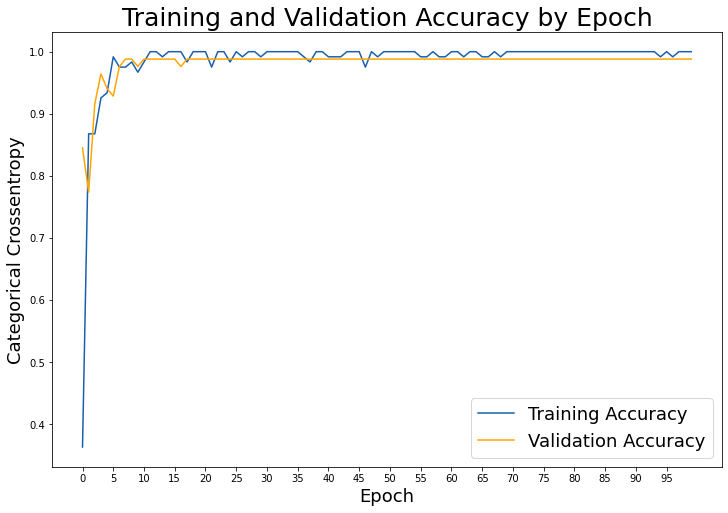

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
import matplotlib.pyplot as plt
# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [ ]:
accuracy=pd.DataFrame(accuracy, columns=['accuracy'])
proj_implemented=pd.DataFrame(proj_implemented, columns=['projection'])
results=pd.concat([accuracy,proj_implemented],axis=1)

In [ ]:
results.groupby('projection').mean()

,accuracy
projection,
linear,0.981071
none,0.982143


In [ ]:
import keras

y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)

res_list = y_classes.tolist()
label_mapping = {0:'Aayush',1:'Kanishk',2:'Kayan',3:'Rohit'}#clarify


for i in range(len(res_list)):
  print("prediction ",i," ",label_mapping[res_list[i]])



prediction  0   Kanishk
prediction  1   Kanishk
prediction  2   Aayush
prediction  3   Kanishk
prediction  4   Kanishk
prediction  5   Rohit
prediction  6   Kayan
prediction  7   Rohit
prediction  8   Kayan
prediction  9   Kayan
prediction  10   Aayush
prediction  11   Kanishk
prediction  12   Kayan
prediction  13   Rohit
prediction  14   Kanishk
prediction  15   Kanishk
prediction  16   Kayan
prediction  17   Aayush
prediction  18   Kayan
prediction  19   Aayush
prediction  20   Aayush
prediction  21   Aayush
prediction  22   Kayan
prediction  23   Rohit
prediction  24   Kanishk
prediction  25   Rohit
prediction  26   Rohit
prediction  27   Aayush
prediction  28   Rohit
prediction  29   Kanishk
prediction  30   Kayan
prediction  31   Kanishk
prediction  32   Aayush
prediction  33   Kanishk
prediction  34   Kanishk
prediction  35   Kayan
prediction  36   Aayush


In [ ]:
model.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.3979 - accuracy: 0.9459


[0.3979407548904419, 0.9459459185600281]